# Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.models import load_model
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Activation, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing data and pre-processing

In [3]:
df=pd.read_csv(r"/content/drive/MyDrive/Asian_paints_15Y.csv",index_col="Date",parse_dates=True)
dfv=pd.read_csv(r"/content/drive/MyDrive/HINDUUNI_15Y.csv",index_col="Date",parse_dates=True)

In [4]:
#dropping rows with null values in the dataframe
df=df.dropna()
dfv=dfv.dropna()

In [5]:
#Reseting index column of the dataframe to Close
df1=df.reset_index()["Adj Close"]
dfv1=dfv.reset_index()["Adj Close"]

# Between period FY 2014-20 the indian markets experienced a boom, and the volatilty in the market also increased significantly
# Since the data before FY 2014 the had very low volatility, the amount of data available for training from the high volatility years was very limited,
# which created a error in the validation set.
# To avoid this I have selected two large cap stocks whose performance were similar over the period under consideration.

In [6]:
# scaling the data in range (0,1)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df2=sc.fit_transform(np.array(df1).reshape(-1,1))
dfv2=sc.transform(np.array(dfv1).reshape(-1,1))

In [7]:
training_size=int(len(df))
training_data=df2[0:training_size,:]
test_size=(len(dfv))
test_data=dfv2[0:test_size,:]

In [8]:
# Convert an array of values into a dataset matrix
#creating the training data set
def create_dataset(dataset, timestep):
    dataX,dataY=[] , []
    for i in range (len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),0]                         #Ex - storing the values from 1 to 50
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])     #Ex - The output will be 51st day closing price
    return  np.array(dataX), np.array(dataY)

In [9]:
# creating train data and test data
timestep=50
X_train, Y_train =create_dataset(training_data, timestep)
print("X_train will start from "+str(timestep)+" to "+str(len(training_data)-timestep) )
X_test, Y_test = create_dataset(test_data, timestep)

# the test set will be ==>  from (total - timestep-1) to (total-1)

X_train will start from 50 to 3828


In [10]:
# reshaping the in 3D
# for LSTM we have input shape as (n_x, m, T_x) -- 3D
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)   #Shape ==> ((training_size - timestep-1),timestep, 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# Model

In [11]:
model =Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1],1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)])

In [12]:
model.summary()

#Summary shows the output shape of an LSTM

#input shape of LSSTM ==> (Batch_size, timesteps, input_dims)
#output shape of LSTM ==> (Batch_size, timesteps, number of units)      -- When return sequences is True
#output shape of LSTM ==> (Batch_size,  number of units)      -- When return sequences is False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 100)          20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 100)          60400     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 100)          60400     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 1

# Training

In [13]:
history=model.fit(X_train,Y_train,validation_data =(X_test, Y_test), epochs =50,
                    batch_size=32,
                   verbose=1)

Epoch 1/50
120/120 [==============================] - 28s 61ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 4.4990e-04 - val_root_mean_squared_error: 0.0212
Epoch 2/50
120/120 [==============================] - 6s 48ms/step - loss: 3.6921e-04 - root_mean_squared_error: 0.0192 - val_loss: 3.1099e-04 - val_root_mean_squared_error: 0.0176
Epoch 3/50
120/120 [==============================] - 4s 29ms/step - loss: 3.1358e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.1060e-04 - val_root_mean_squared_error: 0.0176
Epoch 4/50
120/120 [==============================] - 3s 29ms/step - loss: 2.6171e-04 - root_mean_squared_error: 0.0162 - val_loss: 2.8865e-04 - val_root_mean_squared_error: 0.0170
Epoch 5/50
120/120 [==============================] - 4s 35ms/step - loss: 3.5558e-04 - root_mean_squared_error: 0.0189 - val_loss: 2.6036e-04 - val_root_mean_squared_error: 0.0161
Epoch 6/50
120/120 [==============================] - 4s 32ms/step - loss: 2.5591e-04 - root_mean_

# Saving the trained model

In [21]:
model.save("my_model.model",save_format="h5")

# Importing saved model

In [22]:
model = load_model('/content/my_model.model')

# Validation

In [23]:
# Prediction
train_predict=model.predict(X_train)
test_predict= model.predict(X_test)

120/120 [==============================] - 1s 12ms/step


In [24]:
# Scale back the predictions to original values (Initally we had scaled down to range 0-1)
train_predict =sc.inverse_transform(train_predict)
test_predict =sc.inverse_transform(test_predict)

## Performance Metrics (RMSE)

In [25]:
import math
from sklearn.metrics import mean_squared_error
Train_RMSE=math.sqrt(mean_squared_error(sc.inverse_transform(Y_train.reshape(-1,1)),train_predict))
Test_RMSE=math.sqrt(mean_squared_error(sc.inverse_transform(Y_test.reshape(-1,1)),test_predict))
Train_RMSE,Test_RMSE

(18.045288562881005, 21.164072243401044)

## Validation plot

train end at  3877
test start at 3928
test end at 3877
Test length -51
The shape of X_test 3825


<Figure size 1600x600 with 0 Axes>

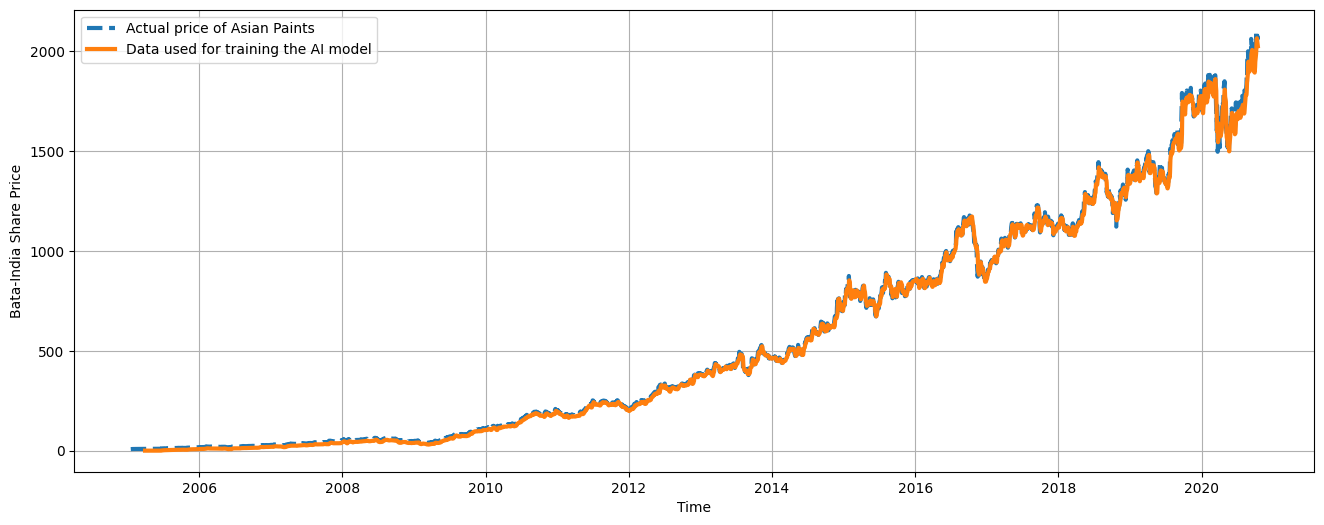

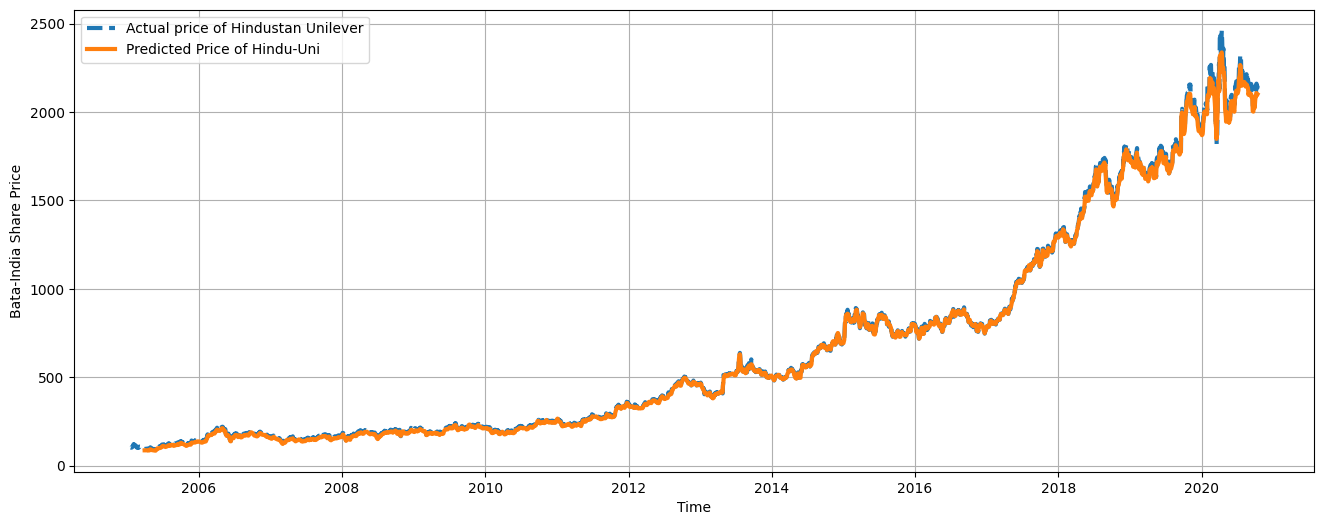

In [37]:
dates=np.array(df.index)
plt.figure(figsize=(16,6))
look_back=timestep
# Shift train predictions for plotting
trainplot=np.empty_like(df2)
trainplot[:, :] =np.nan
trainplot[look_back:len(train_predict)+look_back, :] = train_predict
print("train end at ",len(train_predict)+look_back)

# Shift test predictions for plotting
testplot=np.empty_like(df2)
testplot[:, :] =np.nan

print("test start at",len(train_predict)+2*look_back+1)
print("test end at",len(df2)-1)
print("Test length",len(df2)-1-(len(train_predict)+2*look_back+1))
print("The shape of X_test",X_test.shape[0])

testplot[look_back:len(test_predict)+look_back, :] = test_predict     #For two share
#testplot[len(train_predict)+2*look_back+1:len(df2)-1, :] = test_predict
#2*look_back covers the previous the previous 100 timesteps data included in training/testing the model
# For testing the data will come from (len(train_predict+look_back) : len(train_predict+2*look_back) )
#==> the first prediction will come at [len(train_predict)+2*look_back+1]

# Plotting baseline and predictions
plt.figure(figsize=(16,6))
plt.plot(dates,sc.inverse_transform(df2), linestyle='dashed',linewidth=3,label="Actual price of Asian Paints")
plt.plot(dates,trainplot,linewidth=3,label="Data used for training the AI model")
#plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of BataIndia")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16,6))
plt.plot(dates[2:],sc.inverse_transform(dfv2), linestyle='dashed',linewidth=3,label="Actual price of Hindustan Unilever")
plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of Hindu-Uni")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

# Prediciton

In [38]:
x_input=training_data[len(training_data)-look_back:].reshape(-1,1) #Taking previous day 100 data
temp_input=list(x_input)
x_input.shape

(50, 1)

In [39]:
from numpy import array
lst_output=[] #empty list
n_steps =look_back
i=0
while (i<30):
    if(len(temp_input)>look_back):
        #print(temp_input)
        x_input=np.array(temp_input[1:])   #gets prev 100 day data from latest(updated) temp_input
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        x_input=tf.convert_to_tensor(x_input,dtype=tf.float32)

        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.9675536]
51
1 day output [[0.9596154]]
2 day output [[0.9490548]]
3 day output [[0.93779343]]


<ipython-input-39-492275b2d6a9>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_input=np.array(temp_input[1:])   #gets prev 100 day data from latest(updated) temp_input


4 day output [[0.9267716]]
5 day output [[0.91643685]]
6 day output [[0.90702385]]
7 day output [[0.89864534]]
8 day output [[0.8913091]]
9 day output [[0.8849891]]
10 day output [[0.8795739]]
11 day output [[0.87478304]]
12 day output [[0.87026507]]
13 day output [[0.86582434]]
14 day output [[0.8612487]]
15 day output [[0.85645974]]
16 day output [[0.8513799]]
17 day output [[0.8460629]]
18 day output [[0.84050244]]
19 day output [[0.83471364]]
20 day output [[0.82893443]]
21 day output [[0.8233065]]
22 day output [[0.81804985]]
23 day output [[0.813278]]
24 day output [[0.8090627]]
25 day output [[0.8052811]]
26 day output [[0.8018542]]
27 day output [[0.7987838]]
28 day output [[0.7958756]]
29 day output [[0.79293233]]
[[0.9675536155700684], [0.9596154093742371], [0.9490547776222229], [0.9377934336662292], [0.9267715811729431], [0.9164368510246277], [0.9070238471031189], [0.8986453413963318], [0.8913090825080872], [0.8849890828132629], [0.8795738816261292], [0.8747830390930176], [0

In [40]:
df3=df2.tolist()
df3.extend(lst_output) # adding the latest output to the existing data

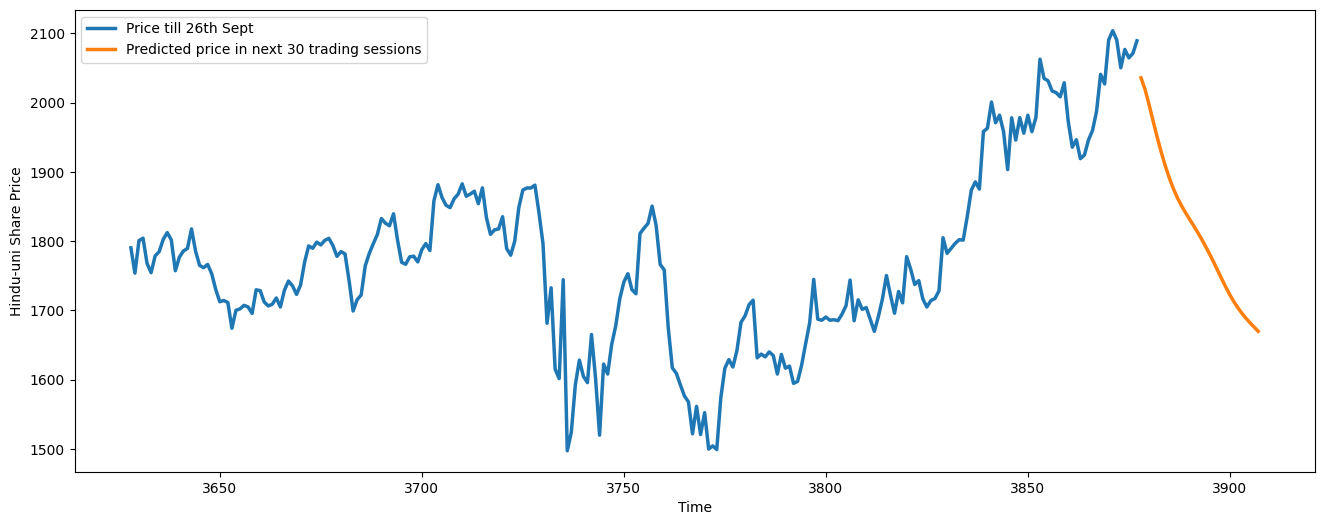

In [41]:
plt.figure(figsize=(16,6))

timeframe_prev =list(range(len(df2)-250, len(df2)))
plt.plot(timeframe_prev,sc.inverse_transform(df2[len(df2)-250:]), label="Price till 26th Sept",linewidth=2.5)

timeframe =list(range(len(df2), len(df2)+30))
plt.plot(timeframe,sc.inverse_transform(lst_output), label="Predicted price in next 30 trading sessions",linewidth=2.5)

plt.xlabel('Time')
plt.ylabel('Hindu-uni Share Price')
plt.legend()
plt.show()

## Combined plot with previous data

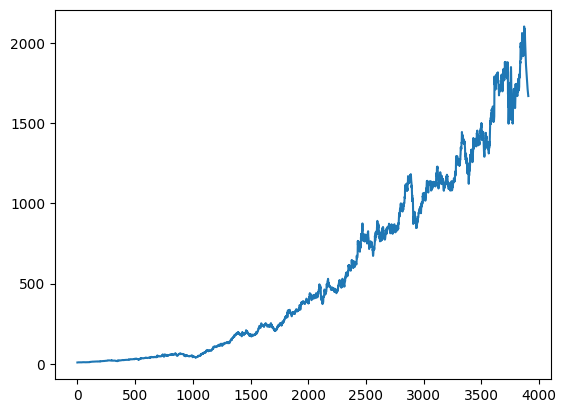

In [46]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(sc.inverse_transform(df3[0:]))